In [1]:
# Load modules
import datacube
import os
import sys
import warnings
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.image as mpimg
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from matplotlib import pyplot as plt
import geopandas as gp
import fiona
from datacube import helpers

import rasterio
import sklearn
import graphviz 
import pdb
from sklearn import tree
from rasterio.features import rasterize

# Import external functions from dea-notebooks using relative link to 10_Scripts
sys.path.append('/g/data/u46/users/sc0554/dea-notebooks/Scripts')
from dea_bandindices import calculate_indices
import dea_classificationtools
from dea_plotting import display_map

In [2]:
#'Wrappers' to translate xarrays to np arrays and back for interfacing with sklearn models
def sklearn_flatten(input_xr):
    """
    Reshape a DataArray or Dataset with spatial (and optionally temporal) structure into 
    an np.array with the spatial and temporal dimensions flattened into one dimension.
    
    This flattening procedure enables DataArrays and Datasets to be used to train and predict
    with sklearn models.
    
    Last modified: September 2019
    
    Parameters
    ----------  
        input_xr : a DataArray or Dataset. Must have dimensions 'x' and 'y', may have dimension 'time'.
                   Dimensions other than 'x', 'y' and 'time' are unaffected by the flattening.
                   
    Returns
    ----------
        input_np : a numpy array corresponding to input_xr.data (or input_xr.to_array().data), with
                   dimensions 'x','y' and 'time' flattened into a single dimension, which is the first
                   axis of the returned array. input_np contains no NaNs.
    
    """
#     pdb.set_trace()
    #cast input Datasets to DataArray
    if isinstance(input_xr,xr.Dataset):
        input_xr = input_xr.to_array()
    
    #stack across pixel dimensions, handling timeseries if necessary
    if 'time' in input_xr.dims:
        stacked = input_xr.stack(z=['x','y','time'])
    else:
        stacked = input_xr.stack(z=['x','y'])
        
    #finding 'bands' dimensions in each pixel - these will not be flattened as their context is important for sklearn
    pxdims = []
    for dim in stacked.dims:
        if dim != 'z':
            pxdims.append(dim)
    
    #mask NaNs - we mask pixels with NaNs in *any* band, because sklearn cannot accept NaNs as input
    mask = np.isnan(stacked)
    if len(pxdims)!=0:
        mask = mask.any(dim=pxdims)
        
    #turn the mask into a numpy array (boolean indexing with xarrays acts weird)
    mask=mask.data
    #the dimension we are masking along ('z') needs to be the first dimension in the underlying np array for
    #the boolean indexing to work
    stacked = stacked.transpose('z',*pxdims)
    input_np = stacked.data[~mask]
    
    return input_np

In [3]:
dc = datacube.Datacube(app = 'classifiers')

In [4]:
#open the shapefile
shp_path='/g/data1a/u46/users/sc0554/LCCS/LCCS/decision_tree/training_data/training_samples_2015_-11_-35.shp'
# shp_path='/g/data1a/u46/users/sc0554/LCCS/LCCS/decision_tree/training_data/LANDSCAPE_SALandCover_TrainingData_PointsConsolidated_SAOnly.shp'
shapes=fiona.open(shp_path,'r')
# shp = gp.read_file(shp_path)
crs=geometry.CRS(shapes.crs_wkt)
field = 'Classvalue'
# field = 'CLASS_VALU'
class_value = 33
product = 'ls8_nbart_geomedian_annual'
query = {
         'time': ('2015-01-01', '2015-02-01')
         }

In [5]:
bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']

In [ ]:
feature_rast_list = []
for feature in shapes:
    # Only process desired class
#     if feature['properties'][field] == class_value:
        # Datacube load the data near each feature in a shapefile, this returns a square / rectamg;e
        f_geometry=feature['geometry']
        geom=geometry.Geometry(f_geometry,crs=crs)
        query['geopolygon'] = geom
        data = dc.load(product=product, group_by='solar_day', **query)
        
        # Calculate indices
        data = calculate_indices(data, 'BUI', collection='ga_ls_2')
        data = calculate_indices(data, 'BSI', collection='ga_ls_2')
        data = calculate_indices(data, 'BSI', collection='ga_ls_2')
        data = calculate_indices(data, 'NBI', collection='ga_ls_2')
        data = calculate_indices(data, 'EVI', collection='ga_ls_2')
        data = calculate_indices(data, 'NDWI', collection='ga_ls_2')
        data = calculate_indices(data, 'MSAVI', collection='ga_ls_2')
    #     data = data.drop(bands)
        # Extract the label
        label = feature['properties'][field]
        # Append training data and label to list
        feature_rast_list.append((data, label))

In [7]:
# affine of single pixel is nans fyi

feature_rast_list = []
for feature in shapes:
    # Only process desired class
#     if feature['properties'][field] == class_value:
        
        # Datacube load the data near each feature in a shapefile, this returns a square / rectamg;e
        f_geometry=feature['geometry']
        geom=geometry.Geometry(f_geometry,crs=crs)
        query['geopolygon'] = geom
        data = dc.load(product=product, group_by='solar_day', **query)

        # Rasterise the feature, this could be improved as it checks every feature in a shapefile.
        mask = rasterize([(feature['geometry'], feature['properties'][field])],
                                           out_shape=data.isel(time=0).green.shape,
                                           transform=data.affine
                                          )
        mask = xr.DataArray(mask, coords=(data.y, data.x))

        # Mask the data so area outside the shapefile is NaN
        data = data.where(mask == feature['properties'][field], np.nan)
        # Calculate indices
        data = calculate_indices(data, 'BUI', collection='ga_ls_2')
        data = calculate_indices(data, 'BSI', collection='ga_ls_2')
        data = calculate_indices(data, 'BSI', collection='ga_ls_2')
        data = calculate_indices(data, 'NBI', collection='ga_ls_2')
        data = calculate_indices(data, 'EVI', collection='ga_ls_2')
        data = calculate_indices(data, 'NDWI', collection='ga_ls_2')
        data = calculate_indices(data, 'MSAVI', collection='ga_ls_2')
        
        # Extract the label
        label = feature['properties'][field]

        # Append training data and label to list
        feature_rast_list.append((data, label))

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/datacube/utils/math.py:105: RuntimeWarning: invalid value encountered in double_scalars
  res = (data[data.size - 1] - data[0]) / (data.size - 1.0)


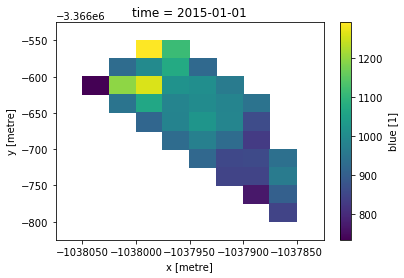

In [10]:
feature_rast_list[0][0].blue.plot()

In [12]:
feature_names = list(data.data_vars)
print(feature_names)
target_names = np.array(('Natural Terrestrial Vegetated', 'Artificial Surface', 'Natural Surface', 'Artificail Water', 'Natural Water'))
print(target_names)

['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'BUI', 'BSI', 'NBI', 'EVI', 'NDWI', 'MSAVI']
['Natural Terrestrial Vegetated' 'Artificial Surface' 'Natural Surface'
 'Artificail Water' 'Natural Water']


In [ ]:
feature_rast_list[0][0].isel(time=0)['BUI'].plot()

In [ ]:
# Flatten arrays and append to list
flat_train_list = []
flat_val_list = []

for feature in feature_rast_list:
    # Flatten
    flat_train = sklearn_flatten(feature[0])
    # Make a list of labels for the same length as the training data
    flat_val = np.repeat(feature[1],flat_train.shape[0])
    flat_train_list.append(flat_train)
    flat_val_list.append(flat_val)

In [ ]:
# Stack list off arrays into single array
# Change to stack
val_input = np.hstack(flat_val_list)
train_input = np.vstack(flat_train_list)
print(train_input.shape, val_input.shape, )

In [ ]:
# Initialise classifier
dtree = tree.DecisionTreeClassifier(random_state=0, max_depth=100)
# Fit classifier add "==215" to make a single class prediction.
dtree = dtree.fit(train_input, val_input)

In [ ]:
# Prints the feature importance
print(dict(zip(feature_names, dtree.feature_importances_)))

In [ ]:
# Plots the structure of the tree
# plt.figure(figsize=(25,8))
# sklearn.tree.plot_tree(dtree, feature_names=feature_names, class_names=['Not Urban', 'Urban']) 

# Prediction

In [ ]:
# load the area you want to predict land cover here

# Lake Eyre
# x = (550000, 600000)
# y = (-3000000, -2950000)
x = (-1000000, -950000)
y = (-3400000, -3350000)

query = {'time': ('2015-01-01', '2015-02-01')}
query['x'] = (x[0], x[1])
query['y'] = (y[0], y[1])
query['crs'] = 'EPSG:3577'

In [ ]:
display_map(x, y, crs="EPSG:3577")

In [ ]:
new_data = dc.load(product=product, group_by='solar_day', **query)

In [ ]:
new_data = calculate_indices(new_data, 'BUI', collection='ga_ls_2')
new_data = calculate_indices(new_data, 'BSI', collection='ga_ls_2')
new_data = calculate_indices(new_data, 'BSI', collection='ga_ls_2')
new_data = calculate_indices(new_data, 'NBI', collection='ga_ls_2')
new_data = calculate_indices(new_data, 'EVI', collection='ga_ls_2')
new_data = calculate_indices(new_data, 'NDWI', collection='ga_ls_2')
new_data = calculate_indices(new_data, 'MSAVI', collection='ga_ls_2')
# new_data = new_data.drop(bands)

In [ ]:
predicted = dea_classificationtools.predict_xr(dtree, new_data)

In [ ]:
(predicted == 215).plot()

In [ ]:
out = predicted.isel(time=0).transpose()
out = out.to_dataset(name="LCCS_L3")
out.attrs['crs']=geometry.CRS(data.crs)
# out = out.isel(time=0)

In [ ]:
helpers.write_geotiff('dtreetest_bandsurb.tif', out)

# Junk code

In [ ]:
new_data_flat = sklearn_flatten(new_data)

In [ ]:
new_data_predict_flat = dtree.predict(new_data_flat)

In [ ]:
np.unique(new_data_predict_flat)

In [ ]:
new_data_predict = dea_classificationtools.sklearn_unflatten(new_data_predict, new_data)

In [ ]:
dot_data = tree.export_graphviz(dtree, out_file=None, 
                      class_names=target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)
graph = graphviz.Source(dot_data)
graph 

In [ ]:
field = 'Classvalue'
shapes = ((geom,value) for geom, value in zip(shp.geometry, 
                                                      shp[field]))

In [ ]:
shapefilepath = '/g/data1a/u46/users/sc0554/LCCS/LCCS/decision_tree/training_data'

In [ ]:
shp = gp.read_file(shapefilepath)

In [ ]:
mask = rasterio.features.rasterize(((feature['geometry'], 1) for feature in shp.iterfeatures()),
                                   out_shape=data.isel(time=0).green.shape,
                                   transform=data.green.affine
                                  )

In [ ]:
for index, row in shp.iterrows():
    print(row)
    break
#     print(row['Classvalue'], row['geometry'])

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)

In [ ]:
iris.target_names

In [ ]:
plt.figure(figsize=(20,20))
tree.plot_tree(clf.fit(iris.data, iris.target), feature_names = iris.feature_names) 